In [17]:
!pip install scanpy
!pip install leidenalg
!pip install optuna

In [25]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import random
import pickle
import sklearn
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from typing import List
## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import defaultdict
import optuna
import gc


In [19]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==2.2.0 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [14]:
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
  
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 4


In [15]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
#dataset='Stephenson'
dataset='COMBAT'

In [7]:
if dataset=='Stephenson':
    # Stephenson Dataset 
    adata = sc.read_h5ad("/kaggle/input/stephenson-et-al-covid-19-single-cell-dataset/Stephenson_processed.h5ad")
    donors = adata.obs['sample_id'].unique()

    # Splitting data into train-test-validation (cant perform cross-validation!)
    test_set= adata[adata.obs['Site']=='Sanger']
    # train_val_set= adata[~(adata.obs['Site']=='Cambridge')]
    train_set= adata[adata.obs['Site']=='Ncl']
    validation_set= adata[adata.obs['Site']=='Cambridge']
    test_patients_ids=test_set.obs['sample_id'].unique()
else: 
    # COMBAT dataset 
    adata = sc.read_h5ad("/kaggle/input/a-blood-atlas-of-covid-19-combat-preprocessed/combat_processed.h5ad")
    donors = adata.obs['scRNASeq_sample_ID'].unique()

    # Splitting data into test and remaining data for cross-validation
    train_val_set_ids, test_ids = train_test_split(
        adata.obs['Pool_ID'].unique(), 
        test_size=0.2,  # 20% of data for testing
        random_state=42  # For reproducibility
    )

    train_val_set = adata[adata.obs['Pool_ID'].isin(train_val_set_ids)]
    test_set = adata[adata.obs['Pool_ID'].isin(test_ids)]
    test_patients_ids=test_set.obs['scRNASeq_sample_ID'].unique()
    train_val_unique_pool_ids = train_val_set.obs['Pool_ID'].unique()


NameError: name 'adata' is not defined

In [44]:
def _filter_missing(distances, target, indicies=None):
    """Leave only observations for which value of `target` is not missing."""
    not_empty_values = target.notna()
    if isinstance(distances, pd.DataFrame):
        distances = distances.loc[not_empty_values, not_empty_values]
        target = target[not_empty_values]
        if indicies is not None:
            test_not_empty_values = target.iloc[indicies].notna().squeeze()
            indicies = indicies[test_not_empty_values]
    else:
        distances = distances[not_empty_values][:, not_empty_values]
        target = target[not_empty_values]
    
    return distances, target, indicies if indicies is not None else target.index

def evaluate_representation(distances, target, indicies=None, method="knn", task="classification", layer='', filename='', **parameters):
    """Evaluate representation of `target` for the given distance matrix

    Parameters
    ----------
    distances : square matrix
        Matrix of distances between samples
    target : array-like
        Vector with the values of a feature for each sample
    method : Literal["knn", "distances", "proportions", "silhouette"]
        Method to use for evaluation:
        - knn: predict values of `target` using K-nearest neighbors and evaluate the prediction
        - distances: test if distances between samples are significantly different from the null distribution
        - proportions: test if distribution of `target` differs between groups (e.g. clusters)
        - silhouette: calculate silhouette score for the given distances
    parameters : dict
        Parameters for the evaluation method. The following parameters are used:
        - knn:
            - n_neighbors: number of neighbors to use for prediction
            - task: type of prediction task. One of "classification", "regression", "ranking". See documentation of `predict_knn` for more information
        - distances:
            - control_level: value of `target` that should be used as a control group
            - normalization_type: type of normalization to use. One of "total", "shift", "var". See documentation of `test_distances_significance` for more information
            - n_bootstraps: number of bootstrap iterations to use
            - trimmed_fraction: fraction of the most extreme values to remove from the distribution
            - compare_by_difference: if True, normalization is defined as difference (as in the original paper). Otherwise, it is defined as a ratio
        - proportions:
            - groups: groups (e.g. cluster numbers) of the observations

    Returns
    -------
    result : dict
        Result of evaluation with the following keys:
        - score: a number evaluating the representation. The higher the better
        - metric: name of the metric used for evaluation
        - n_unique: number of unique values in `target`
        - n_observations: number of observations used for evaluation. Can be different for different targets, even within one dataset (because of NAs)
        - method: name of the method used for evaluation
        There are other optional keys depending on the method used for evaluation.
    """
    distances, target, indicies = _filter_missing(distances, target, indicies)

    if method == "knn":
        y_pred = predict_knn(distances, y_true=target, **parameters)
        result = evaluate_prediction(target, y_pred, indicies, task, layer, filename, **parameters)
        
    elif method == "distances":
        _, score, p_value = test_distances_significance(distances, conditions=target, **parameters)
        result = {"score": score, "p_value": p_value, "metric": "distances", **parameters}
        
    elif method == "proportions":
        if "groups" not in parameters:
            raise ValueError('Please, add "groups" key (for example, with clusters) in the parameters')
        result = test_proportions(target, parameters["groups"])
        
    elif method == "silhouette":
        score = silhouette_score(distances, labels=target, metric="precomputed")
        result = {"score": score, "metric": "silhouette"}

    result["n_unique"] = len(np.unique(target))
    result["n_observations"] = len(target)  # Adjusted for missing values
    result["method"] = method
    
    return result


def predict_knn(distances, y_true, n_neighbors: int = 3, task="classification"):
    """Predict values of `y_true` using K-nearest neighbors

    Parameters
    ----------
    distances : square matrix
        Matrix of distances between samples
    y_true : array-like
        Vector with the same length as `distances` containing values for prediction
    n_neighbors : int = 3
        Number of neighbors to use for prediction
    task : Literal["classification", "regression", "ranking"]
        Type of prediction task:
        - classification: predict class labels
        - regression: predict continuous values
        - ranking: predict ranks of the values. Currently, formulated as a regression task

    Returns
    -------
    y_predicted : array-like
        Predicted values of `target` for samples with known values of `y_true`
    """
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

    # Diagonal contains 0s forcing using the same sample for prediction
    # This gives the perfect prediction even for random target (super weird)
    # Filling diagonal with large value removes this leakage
    """Predict values of `y_true` using K-nearest neighbors."""
    np.fill_diagonal(distances, np.max(distances) + 1)  # Ensure no zero diagonal
    if task == "classification":
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed", weights="distance")
    elif task == "regression" or task == "ranking":
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="precomputed", weights="distance")
    else:
        raise ValueError(f'Task {task} is not supported, please set one of ["classification", "regression", "ranking"]')

    knn.fit(distances, y_true)
    return knn.predict(distances)


def evaluate_prediction(y_true, y_pred,ind, task,layer,fold, **parameters):
    """Evaluate how well `y_pred` predicts `y_true`

    Parameters
    ----------
    y_true : array-like
        Vector with the values of a feature
    y_pred : array-like
        Vector with the predicted values of a feature
    task : Literal["classification", "regression", "ranking"]
        Type of prediction task. See documentation of `predict_knn` for more information

    Returns
    -------
    result : dict
        Result of evaluation with the following keys:
        - score: score of the prediction
        - metric: name of the metric used for evaluation. The following metrics are currently used:
            - f1_macro_calibrated: F1 score for classification task. Calibrated to have value 0 for random prediction and 1 for perfect prediction
            - spearman_r: Spearman correlation for regression and ranking tasks
    """
    from scipy.stats import spearmanr
    from sklearn.metrics import f1_score

    if task == "classification":
        score = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
        metric = "f1_macro_calibrated"

        n_classes = len(np.unique(y_true))

        if n_classes == 1:
            score = 0
        else:
            # Calibrate the metric. Expected value is 1 / n_classes (e.g. 1/2 for a binary classification)
            # With this calibration score==0 means that the prediction is as good as random
            # score==1 would mean the perfect prediction
            # Note that score can be less than 0 in this case => prediction is worse than random. In this case, it is clipped to 0
            score = (score - 1 / n_classes) / (1 - 1 / n_classes)
            cm=sklearn.metrics.confusion_matrix(y_true,y_pred,labels=None, sample_weight=None, normalize=None)
            # Create a heatmap with annotations
            plt.figure(figsize=(6, 4))
            warnings.simplefilter("ignore", category=UserWarning)
            sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')

            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.title(f'Input: {layer}')
            plt.savefig(filename,format='png', bbox_inches='tight')
            plt.grid(False)
            plt.show()
            plt.close() 
    elif task == "regression" or task == "ranking":
        score = spearmanr(y_true, y_pred).statistic
        metric = "spearman_r"
    else:
        raise ValueError(f"{task} is not valid task")
    
        
    
    
    # For calibrated F1, negative score means worse than random prediction. It doesn't matter to us if it is
    # as good as random or worse, so we clip it to 0.
    # For Spearman correlation, negative score means that nearest neighbors often have values of covariate
    # from the other end of the distribution. It is not very meaningful for us at all, and it is not
    # obvious, what is the minimum possible value in this case. -1 is barely possible, because
    # if the neighbors of a sample have "opposite" values, score for these neighbors would be positive.
    # So we clip it to 0 as well.
    if score < -0.5:
        warnings.warn(f"Score has a big negative value: {score}, which is usually not expected.", stacklevel=1)
    score = np.clip(score, 0, 1)

    return {"score": score, "metric": metric}


In [22]:
!mkdir Plots

------------------------------------------X_pca---------------------------------------------


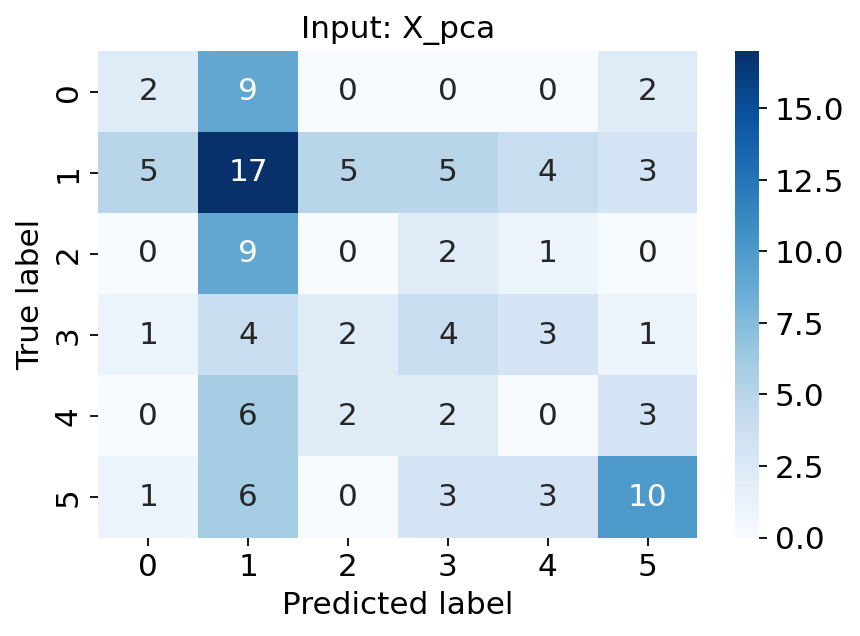

X_pca_representation_5987_4_5_1_137_200_0.09881731201158052_5.308831706373277e-06.csv
{'score': 0.05877019038309364, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.34711825588543027, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


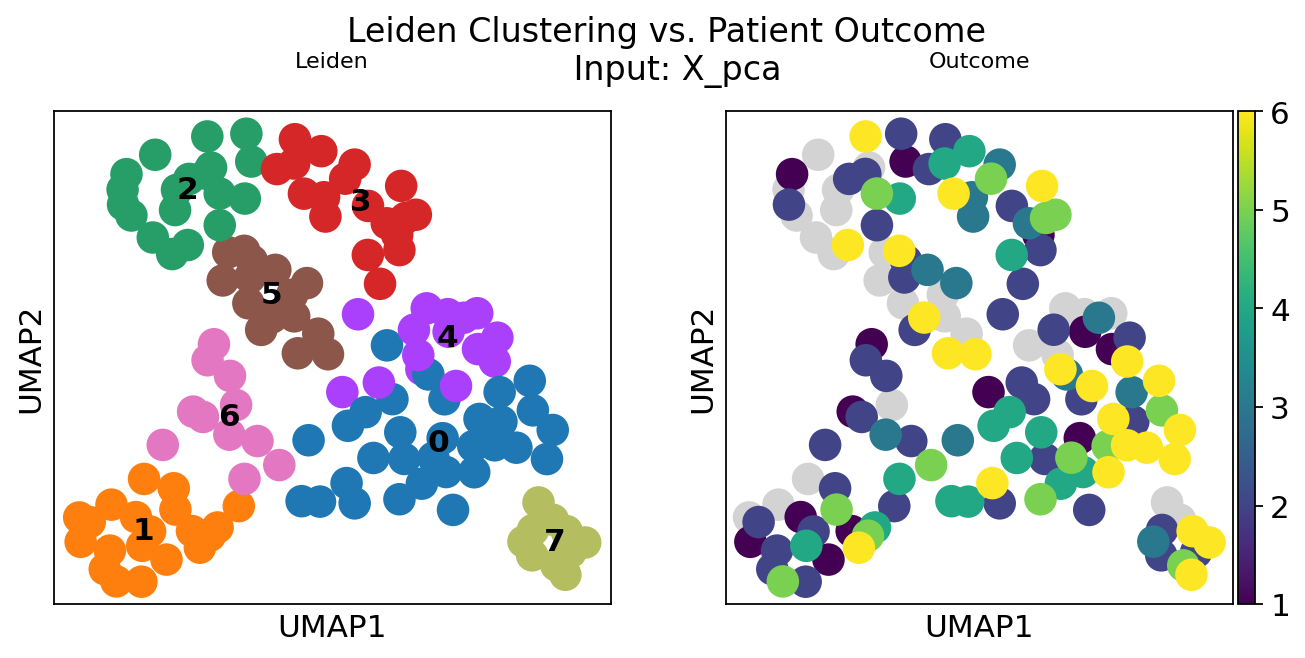

-----------------------------------------------------------------------


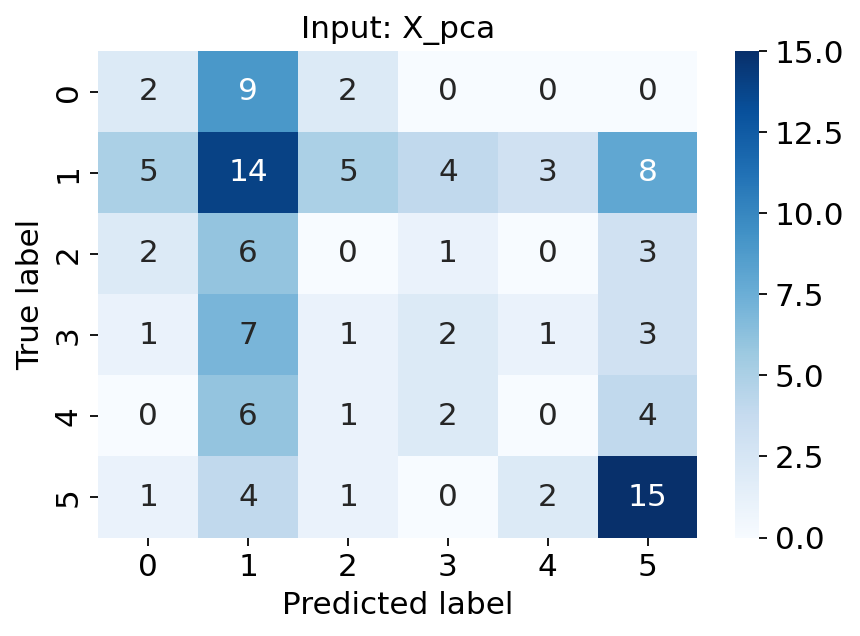

X_pca_representation_5987_2_5_1_137_200_0.09881731201158052_5.308831706373277e-06.csv
{'score': 0.039691876750700336, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.36792525820367, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


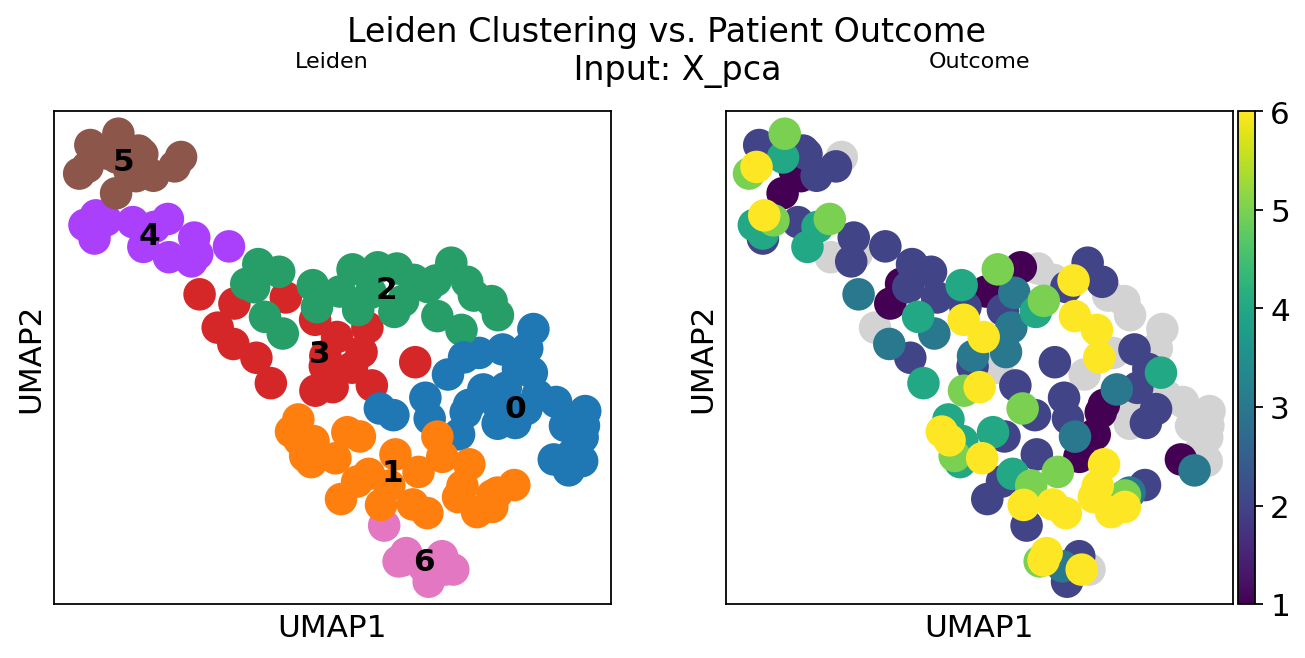

-----------------------------------------------------------------------


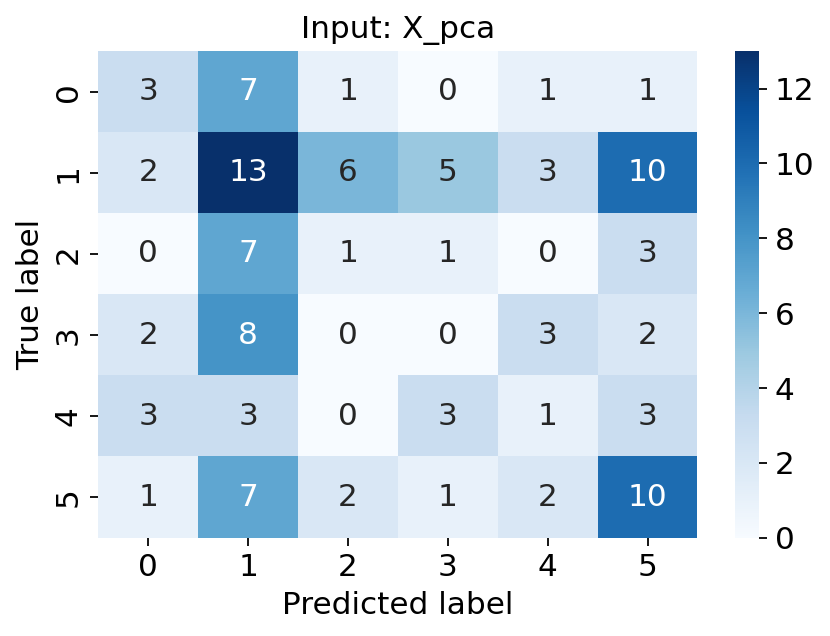

X_pca_representation_5987_3_5_1_137_200_0.09881731201158052_5.308831706373277e-06.csv
{'score': 0.024400961357483063, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.15587947690118575, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


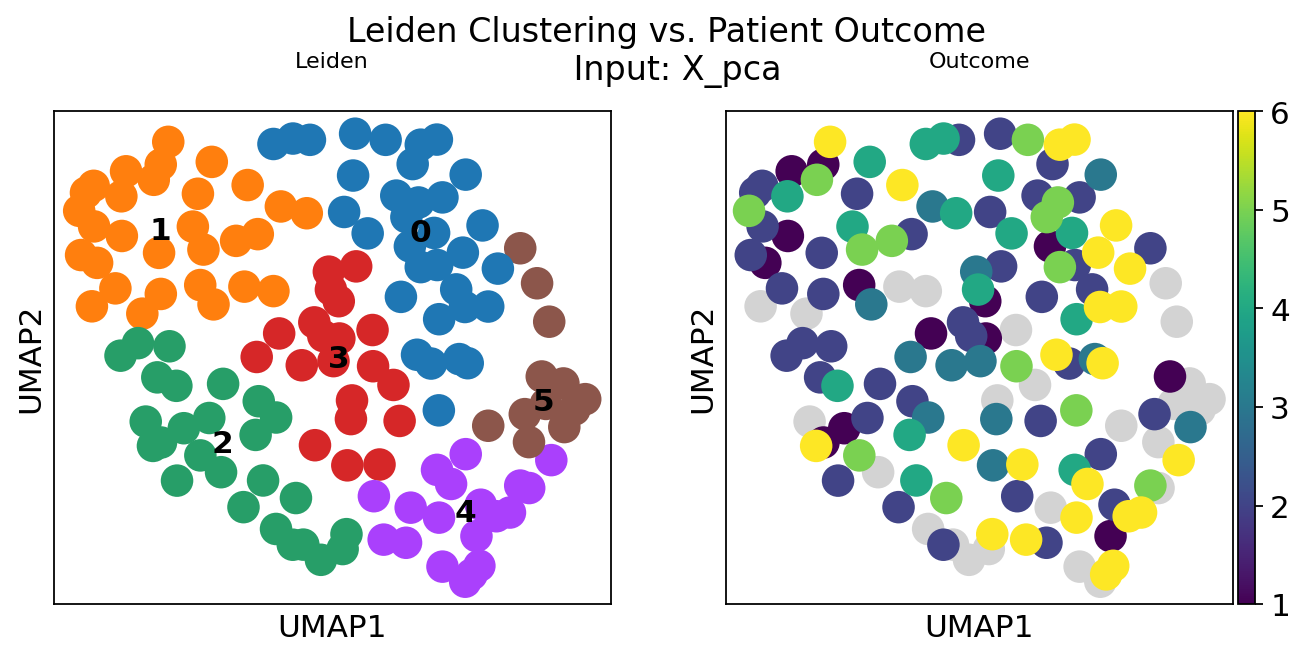

-----------------------------------------------------------------------


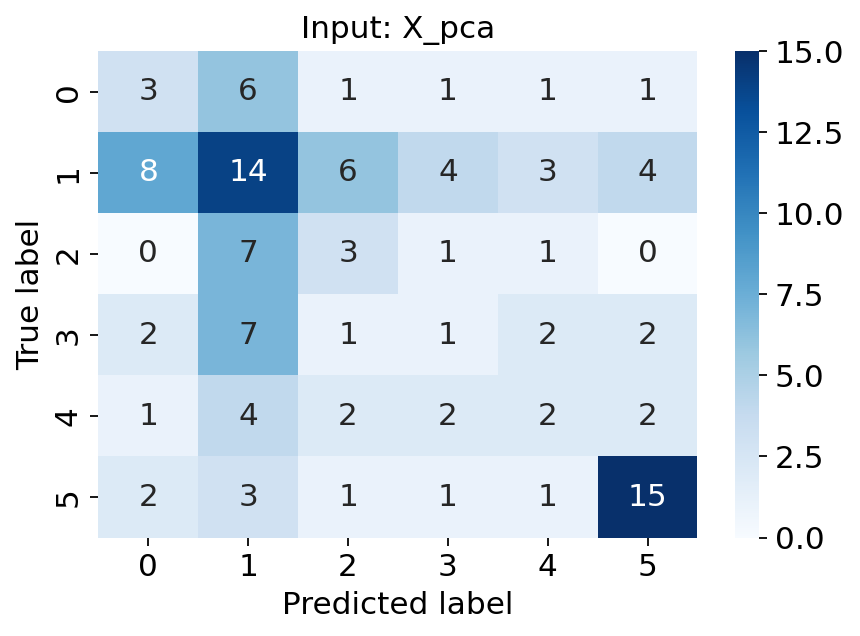

X_pca_representation_5987_0_5_1_137_200_0.09881731201158052_5.308831706373277e-06.csv
{'score': 0.13597533966241107, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.36667774385359647, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


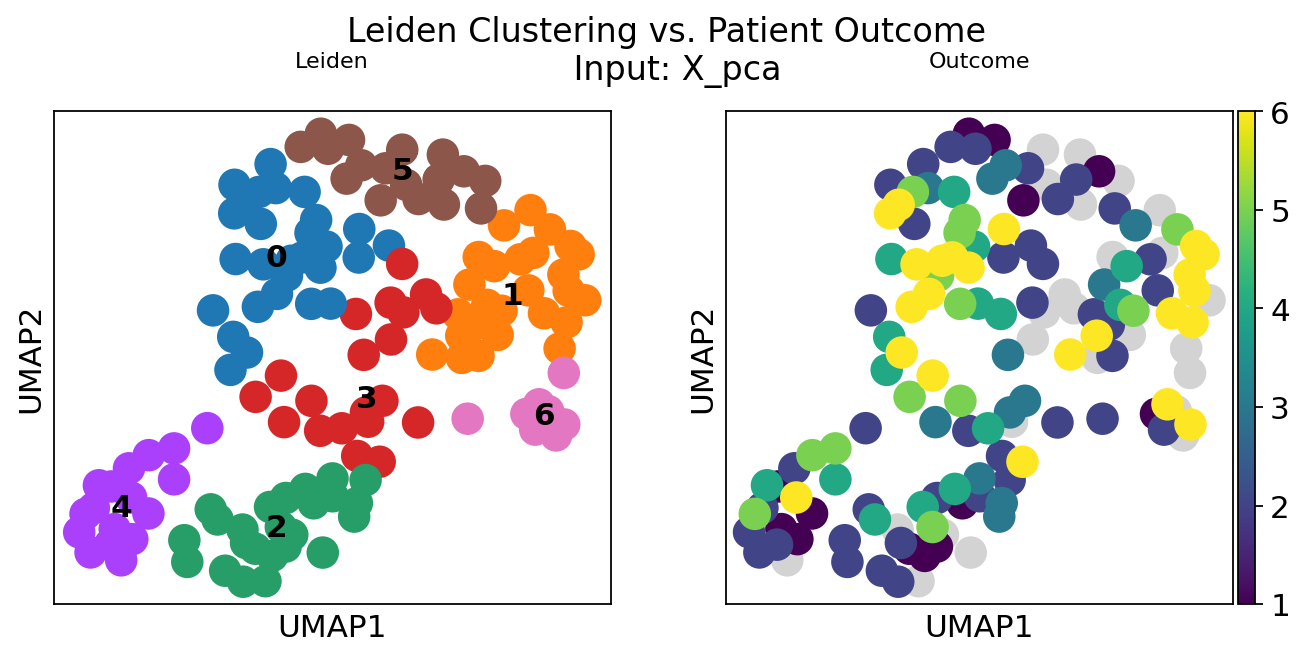

-----------------------------------------------------------------------


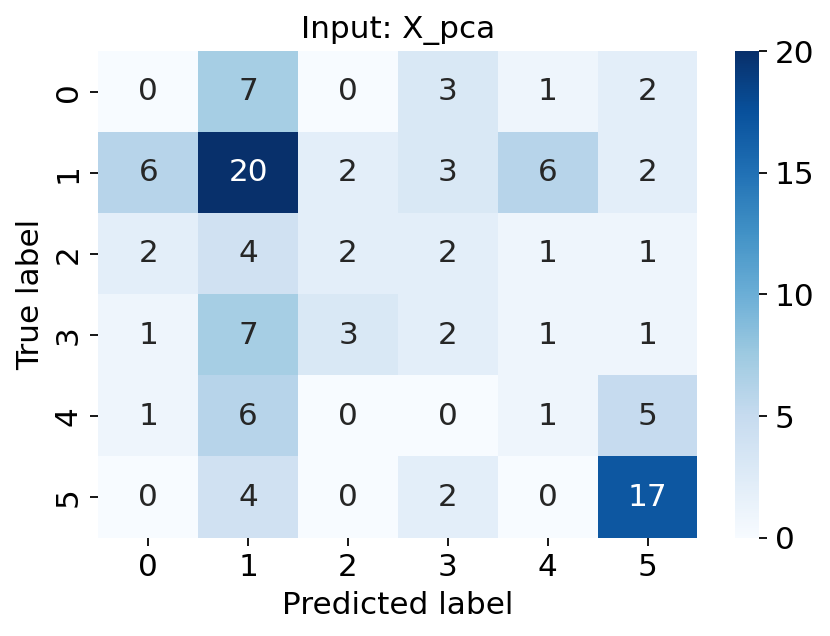

X_pca_representation_5987_1_5_1_137_200_0.09881731201158052_5.308831706373277e-06.csv
{'score': 0.11441355345718958, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.3731826405681429, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


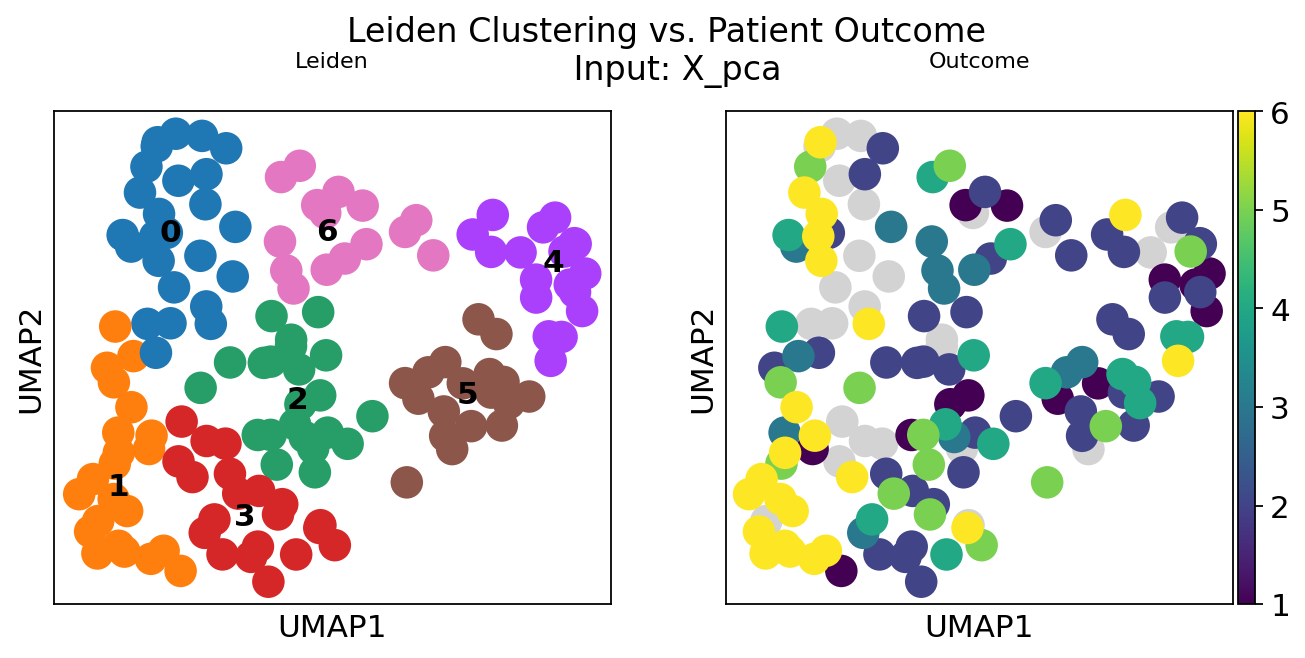

-----------------------------------------------------------------------
------------------------------------------X_scVI_Pool_ID---------------------------------------------


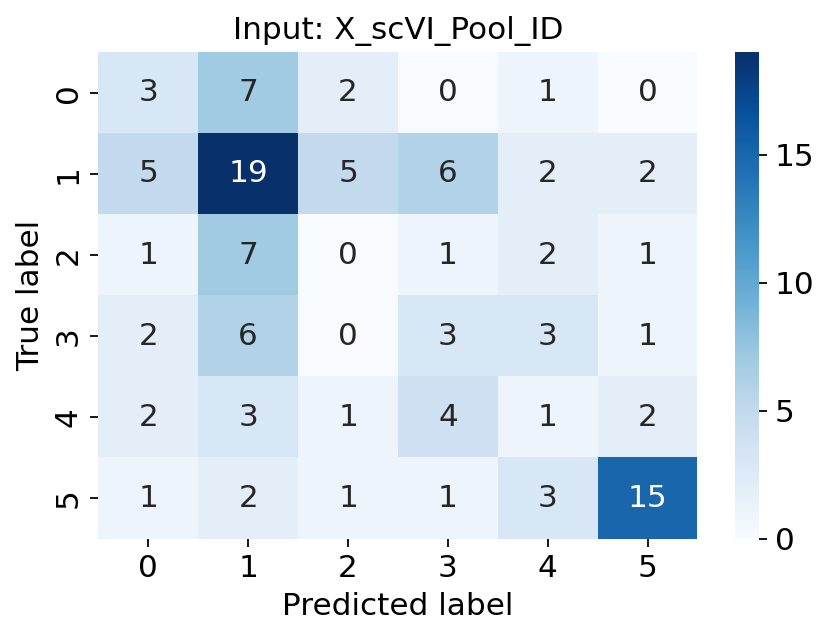

X_scVI_Pool_ID_representation_5486_4_4_1_192_200_0.04319798160786361_4.481584651077825e-05.csv
{'score': 0.12837434586832183, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.4741150152889312, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


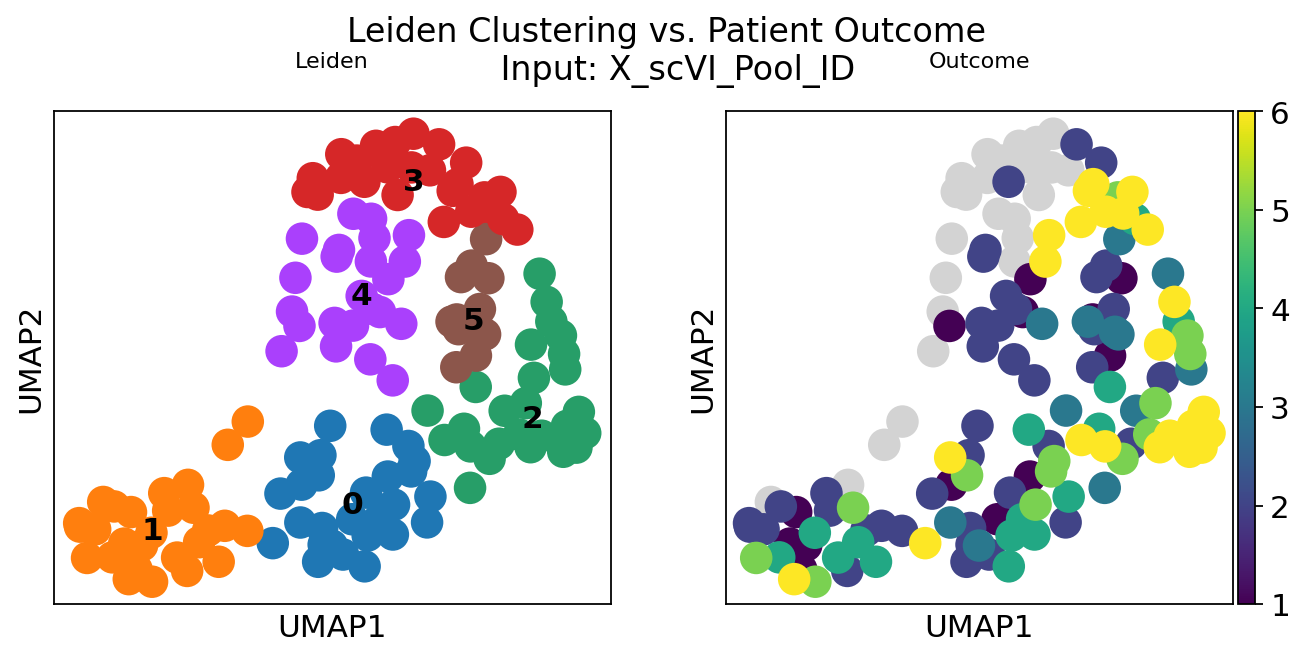

-----------------------------------------------------------------------


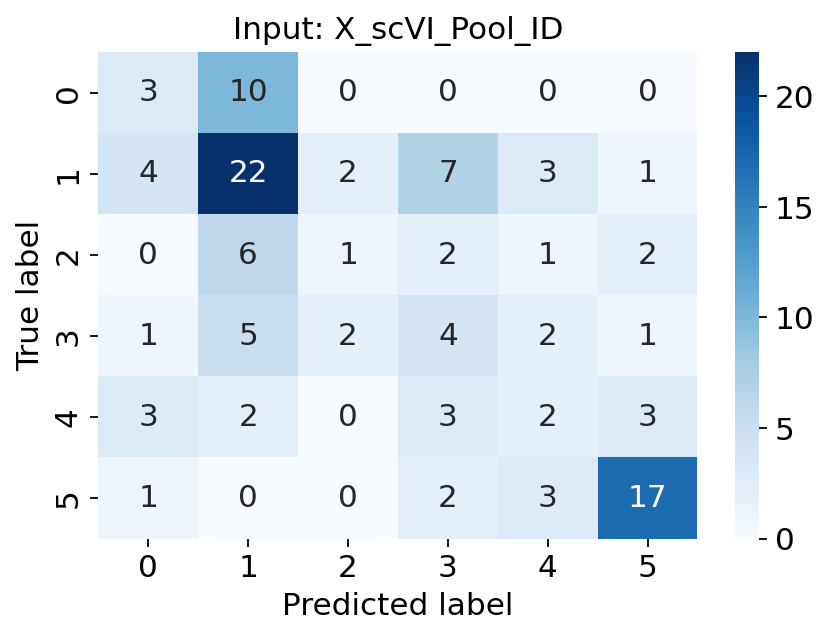

X_scVI_Pool_ID_representation_5486_2_4_1_192_200_0.04319798160786361_4.481584651077825e-05.csv
{'score': 0.2027903494086223, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.5972955345371187, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


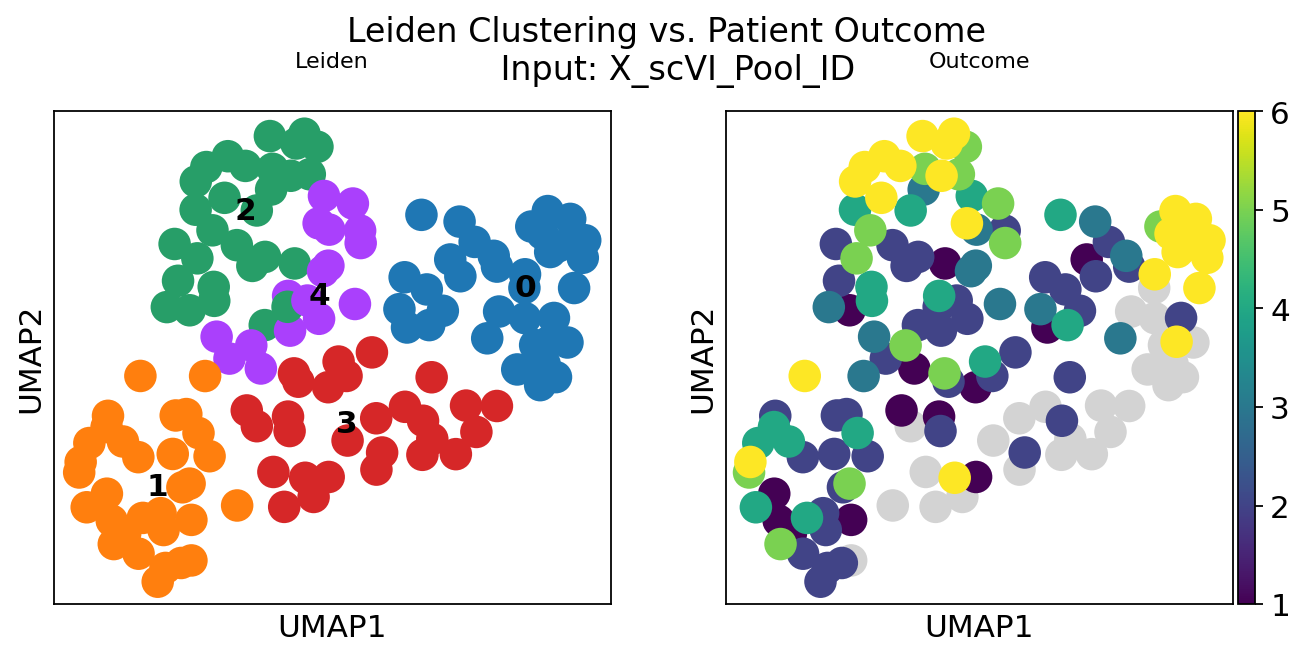

-----------------------------------------------------------------------


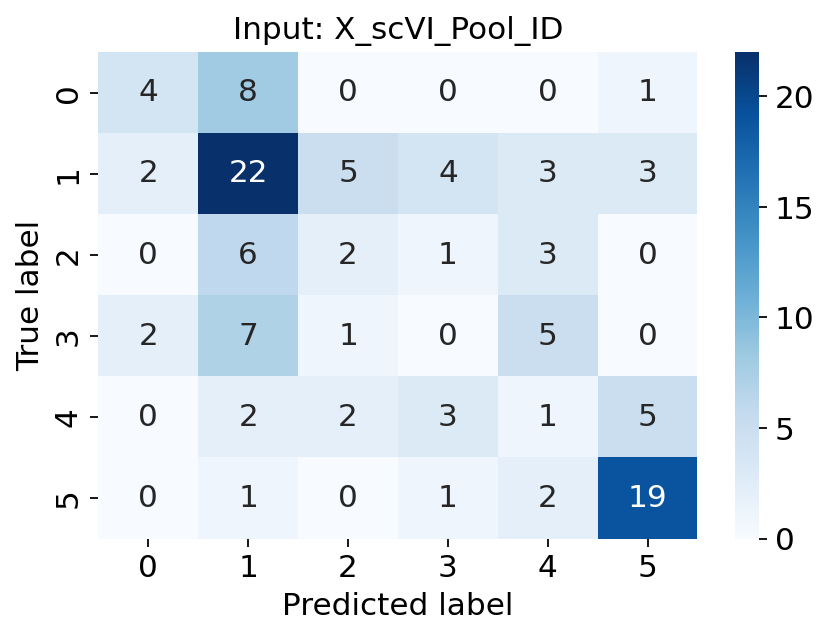

X_scVI_Pool_ID_representation_5486_0_4_1_192_200_0.04319798160786361_4.481584651077825e-05.csv
{'score': 0.17991794697677052, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.6228321862769705, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


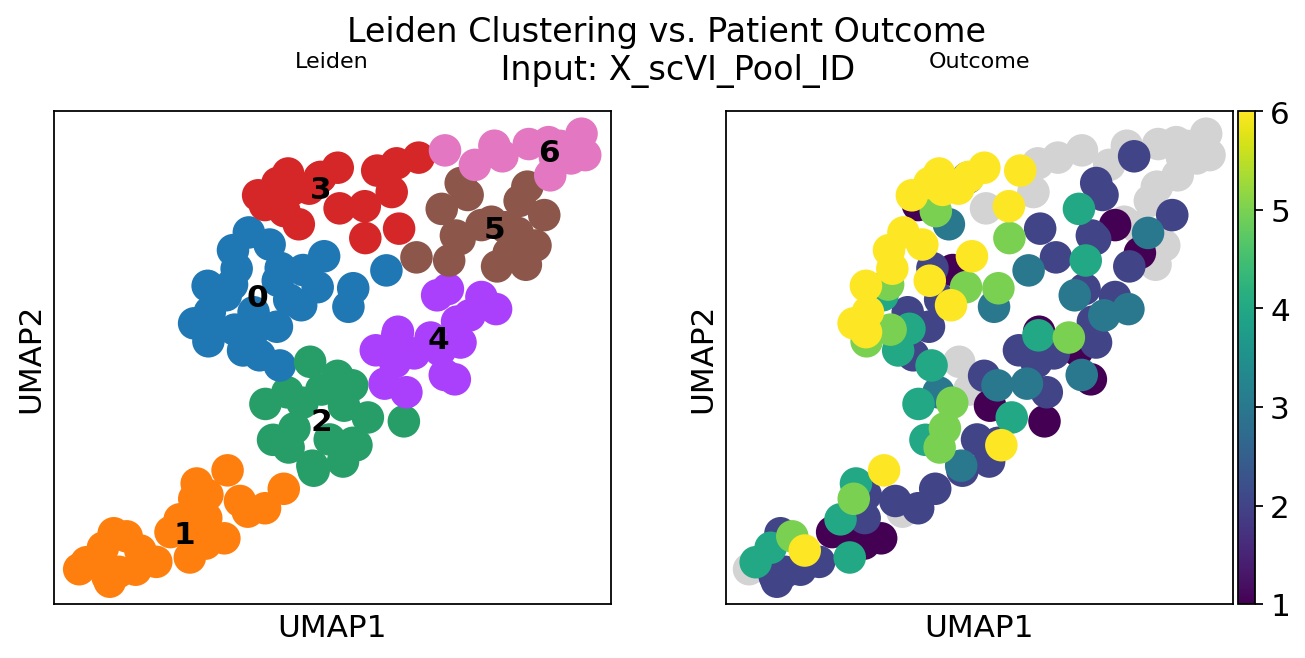

-----------------------------------------------------------------------


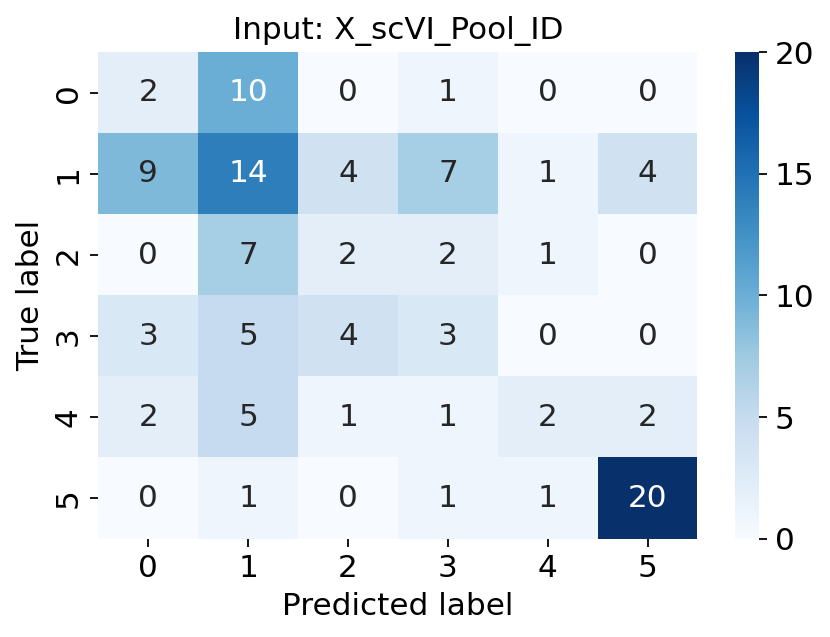

X_scVI_Pool_ID_representation_5486_3_4_1_192_200_0.04319798160786361_4.481584651077825e-05.csv
{'score': 0.17921436862823312, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.5262534091319391, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


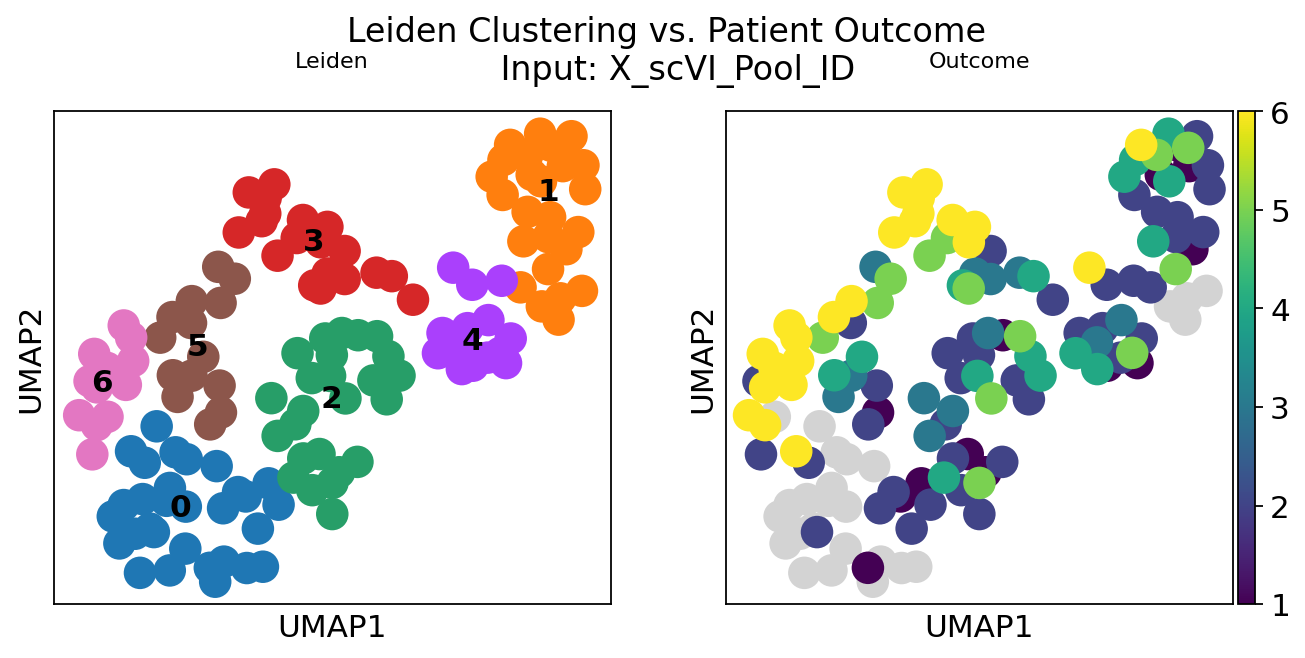

-----------------------------------------------------------------------


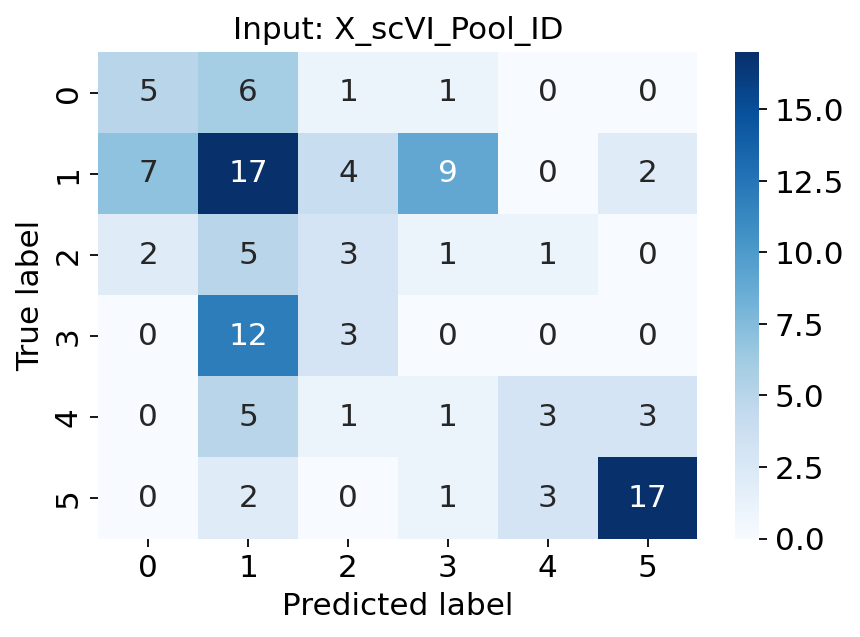

X_scVI_Pool_ID_representation_5486_1_4_1_192_200_0.04319798160786361_4.481584651077825e-05.csv
{'score': 0.21425495262704575, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.5757833041799791, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


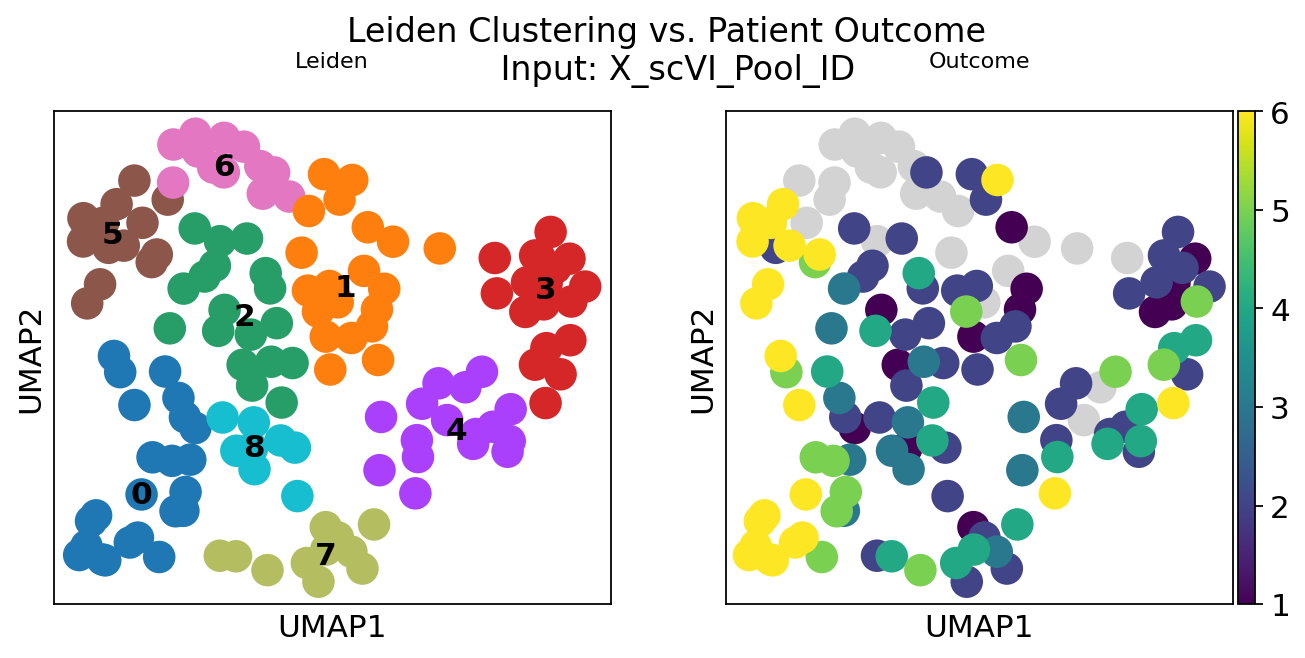

-----------------------------------------------------------------------
------------------------------------------X_scANVI_Pool_ID---------------------------------------------


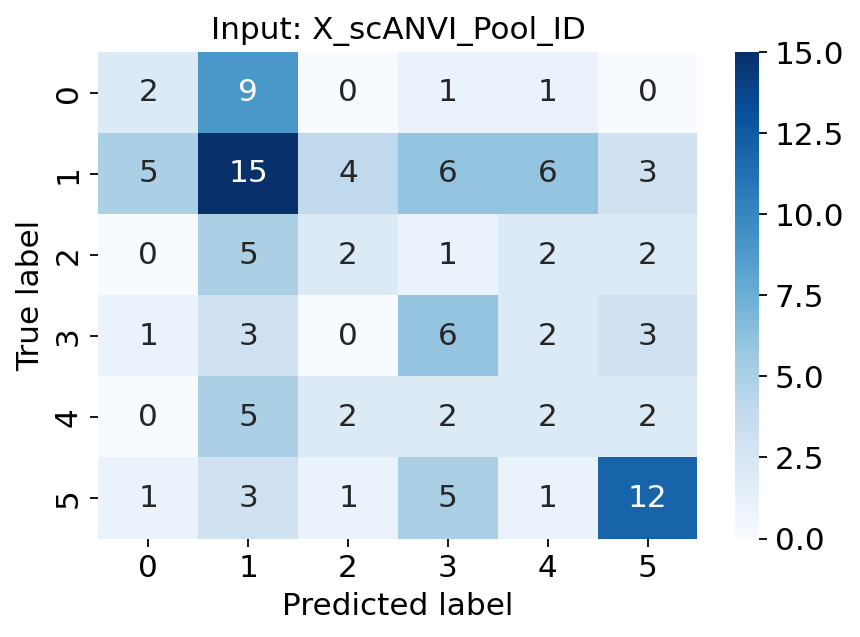

X_scANVI_Pool_ID_representation_5848_4_4_2_257_200_0.05259992816930489_5.436675164988273e-06.csv
{'score': 0.15337120451044498, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.41832008406115323, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


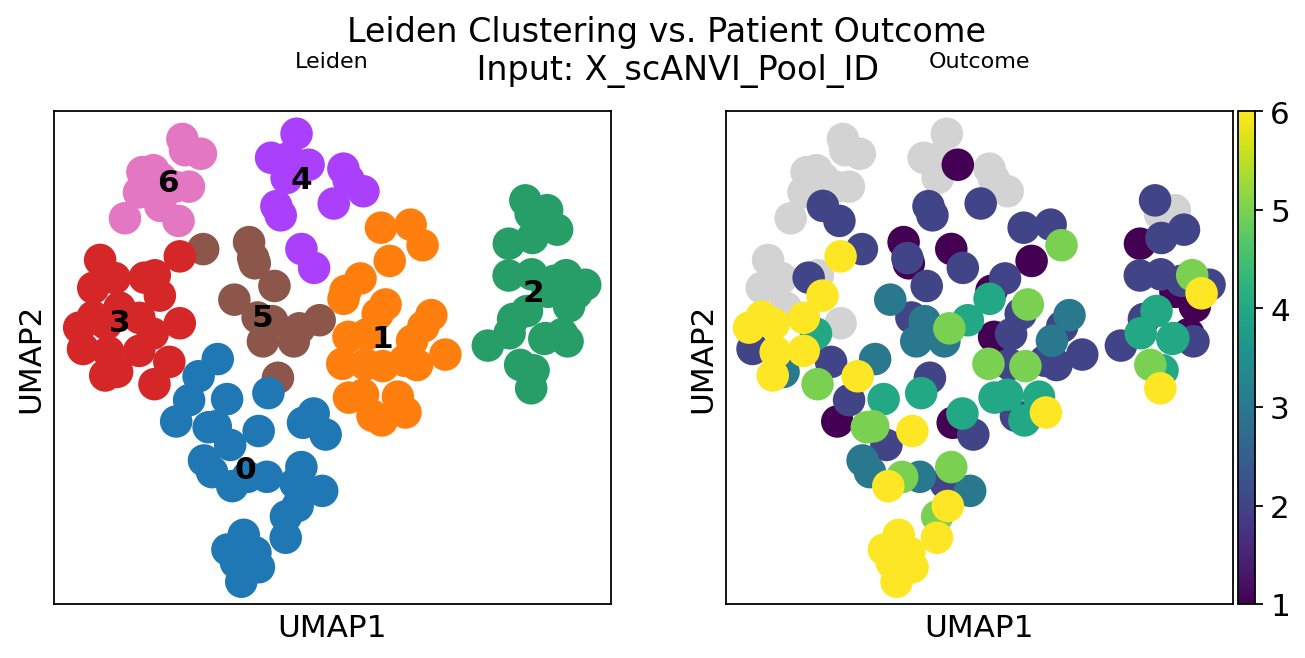

-----------------------------------------------------------------------


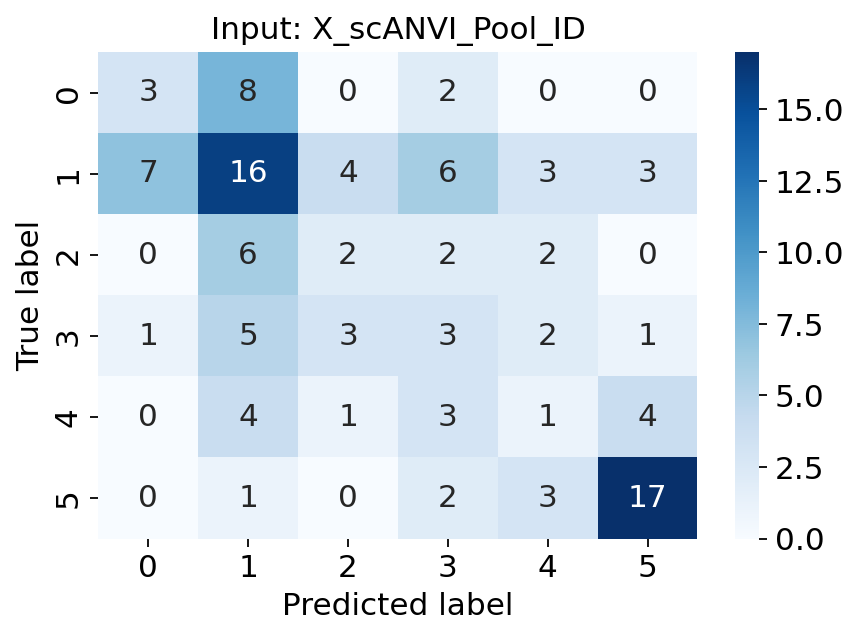

X_scANVI_Pool_ID_representation_5848_1_4_2_257_200_0.05259992816930489_5.436675164988273e-06.csv
{'score': 0.16207326428845417, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.6015343569311394, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


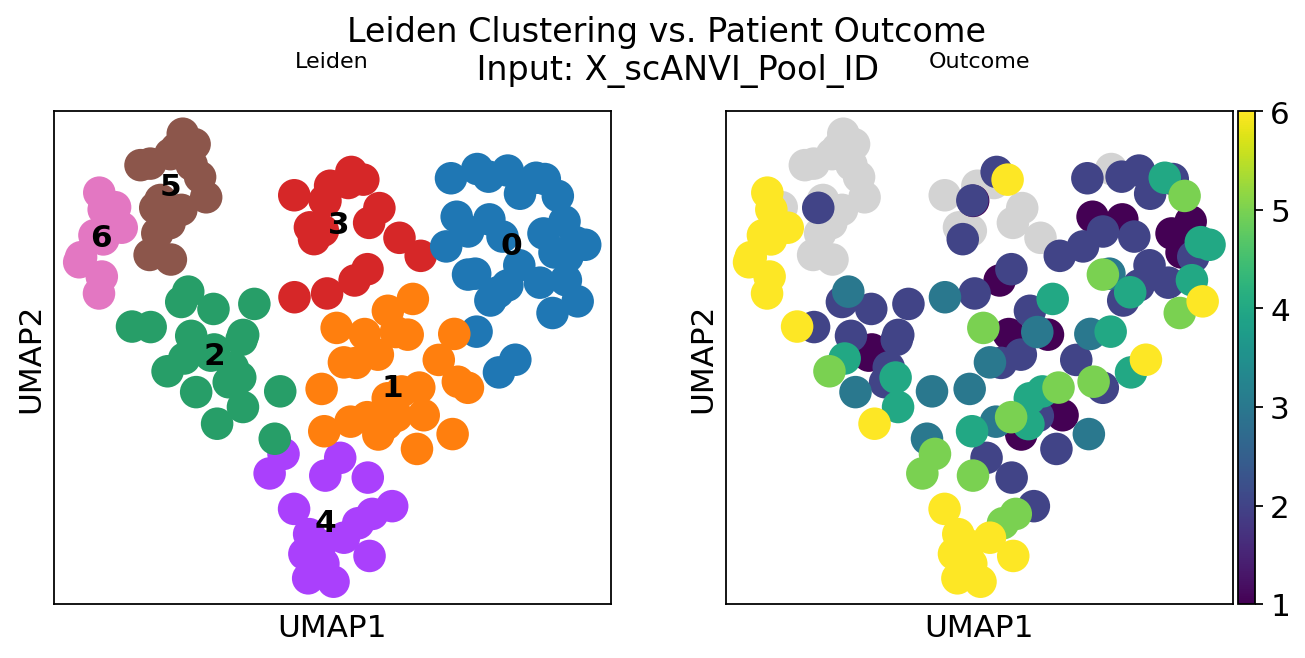

-----------------------------------------------------------------------


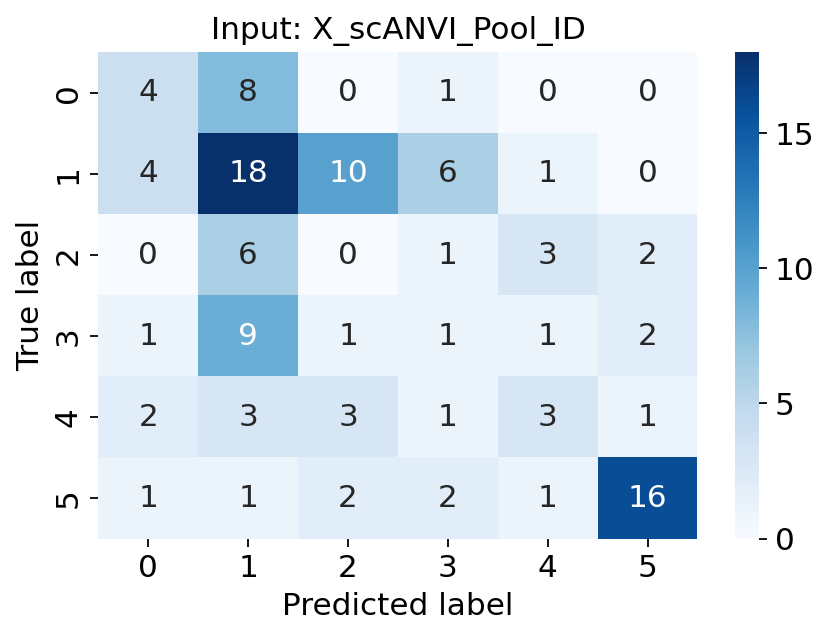

X_scANVI_Pool_ID_representation_5848_3_4_2_257_200_0.05259992816930489_5.436675164988273e-06.csv
{'score': 0.16452910052910052, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.5276886857997911, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


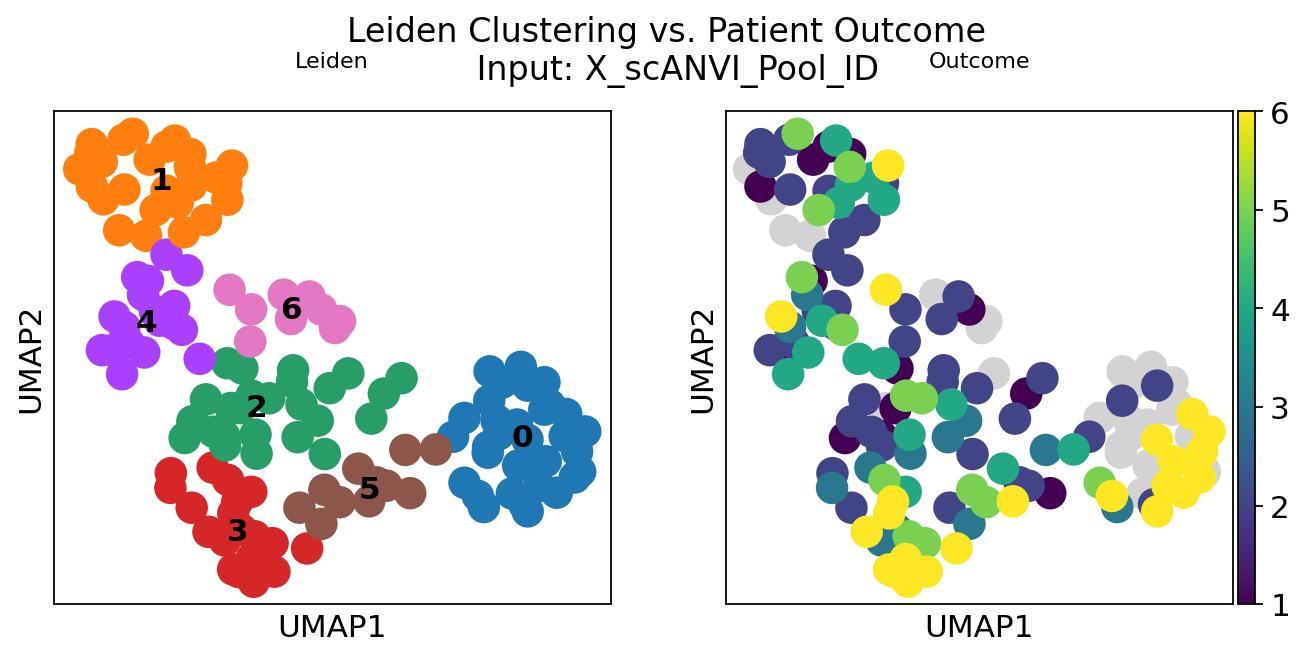

-----------------------------------------------------------------------


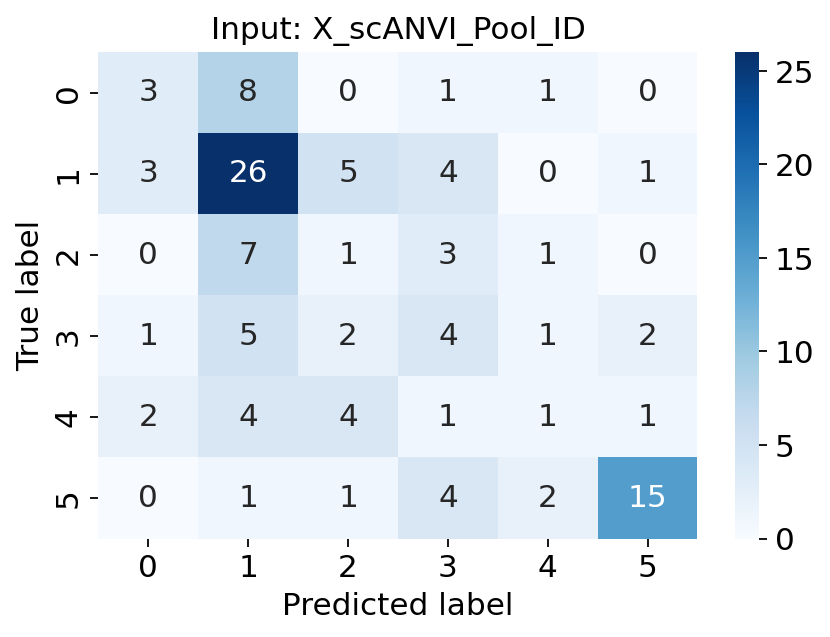

X_scANVI_Pool_ID_representation_5848_0_4_2_257_200_0.05259992816930489_5.436675164988273e-06.csv
{'score': 0.20001078453710033, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.5832989091889755, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


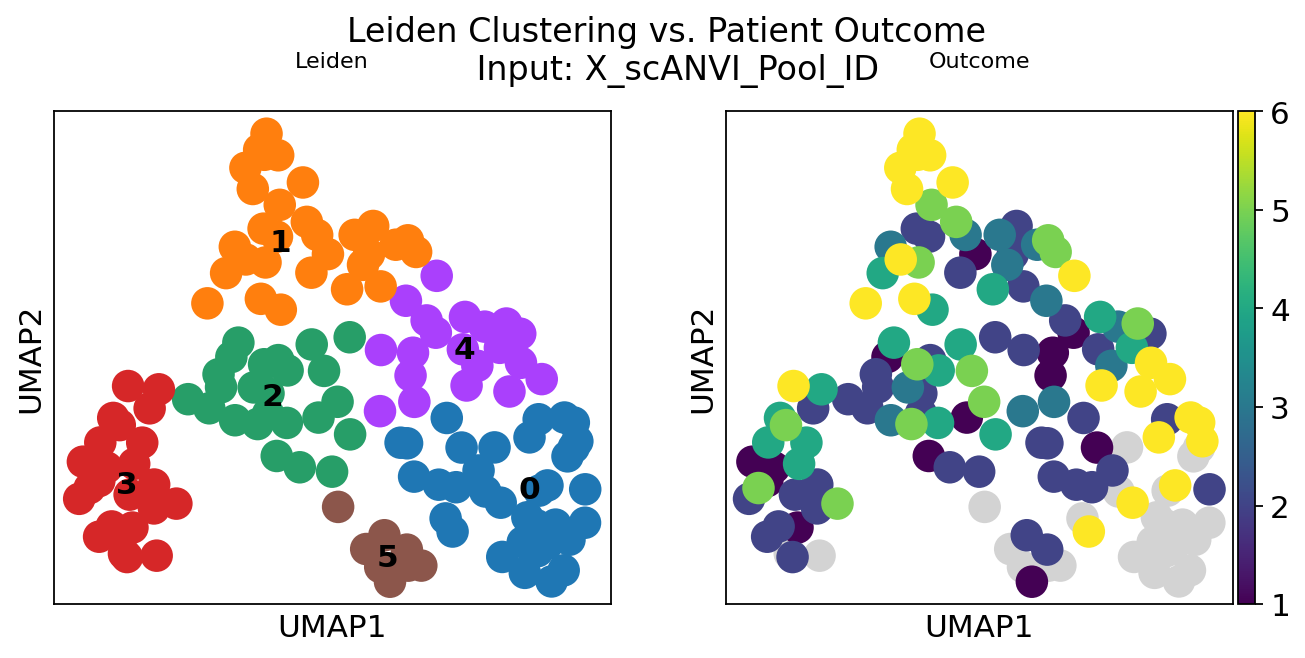

-----------------------------------------------------------------------


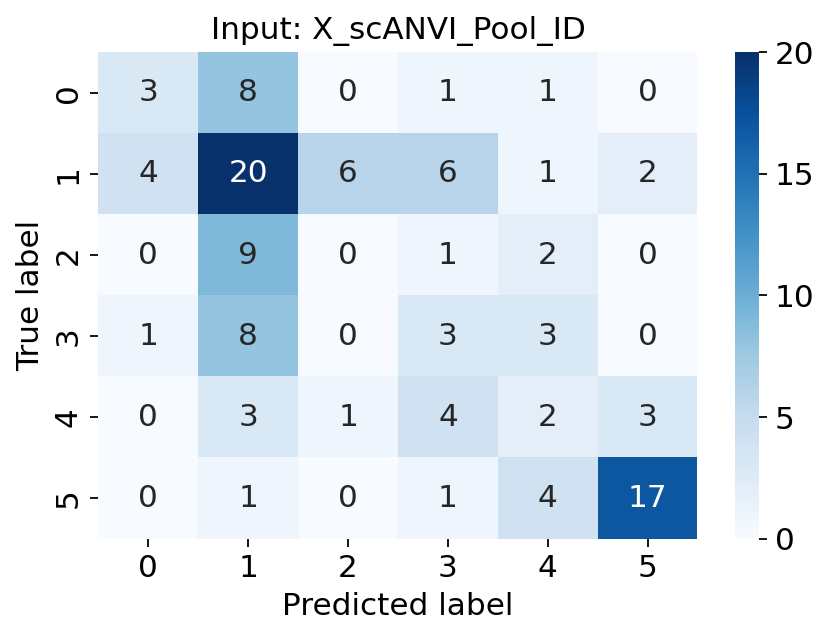

X_scANVI_Pool_ID_representation_5848_2_4_2_257_200_0.05259992816930489_5.436675164988273e-06.csv
{'score': 0.16864196735164477, 'metric': 'f1_macro_calibrated', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
{'score': 0.6193528164119932, 'metric': 'spearman_r', 'n_unique': 6, 'n_observations': 115, 'method': 'knn'}
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


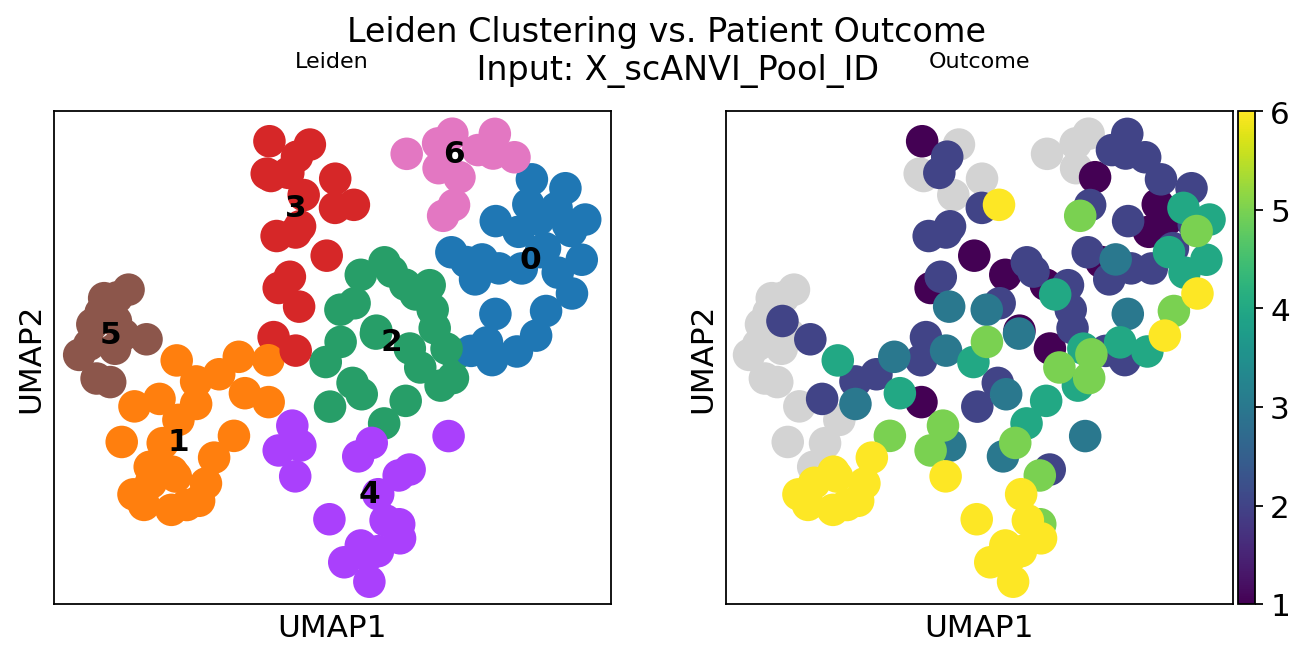

-----------------------------------------------------------------------


In [46]:
import glob
import pickle
all_layer_scores_f1=[]
all_layer_scores_spearman=[]


if dataset == 'COMBAT':
    layers = ['X_pca', 'X_scVI_Pool_ID', 'X_scANVI_Pool_ID']
else:  # 'stephenson'
    layers = ['X_pca', 'X_scVI', 'X_scANVI']

for layer in layers:
#stephenson dataset
#for layer in ['X_pca','X_scVI','X_scANVI']:
    layer_scores_f1=[]
    layer_scores_spearman=[]
    # Adjust file path based on dataset type
    if dataset == 'COMBAT':
        rep_paths = glob.glob('/kaggle/input/final-temp/' + f"{layer}_representation_*")
    else:  # 'stephenson'
        rep_paths = glob.glob('/kaggle/input/steph-whole/' + f"{layer}_representation_*")

    print(f'------------------------------------------{layer}---------------------------------------------')
    # Now, loop through each file path found
    for rep_path in rep_paths:
        filename = rep_path.split('/')[-1]
        parts = filename.split('_')
        hyper = '_'.join(parts[3:-1])
        if layer=='X_pca':
            fold= int(parts[4])
        else: 
            fold=int(parts[6])
        #read in representation 
        representation=pd.read_csv(rep_path)
        representation =pd.DataFrame(representation)
        
        if dataset == 'COMBAT':
            outcome = adata.obs[['scRNASeq_sample_ID', 'Outcome']].drop_duplicates().iloc[:, 1]
        else:  # 'stephenson'
            outcome = adata.obs[['sample_id', 'Status']].drop_duplicates().iloc[:, 1]
        
        
        outcome.index=representation.index
        test_patient_indicies= np.isin(donors, test_patients_ids)
        indicies=np.where(test_patient_indicies)[0]
        distance_matrix = cdist(representation,representation, metric='euclidean')
        outcome_col = 'Outcome' if dataset == 'COMBAT' else 'Status'
        
        score_f1=evaluate_representation(distance_matrix,outcome,indicies,method='knn',n_neighbors=4,layer=layer,filename=str('Plots/'+str(fold)+layer)+'.png')
        score_spearman=evaluate_representation(distance_matrix,outcome,indicies,method='knn',n_neighbors=4,layer=layer,task='ranking',filename=str('Plots/'+str(fold))+layer)
        print(filename)
        print(score_f1)
        print(score_spearman)
        layer_scores_f1.insert(fold,score_f1)
        layer_scores_spearman.insert(fold,score_spearman)
        
        #plot umap 
        outcome=pd.DataFrame(outcome)
        new_adata = sc.AnnData(X=representation,obs=outcome)
        sc.pp.neighbors(new_adata, use_rep="X")
        sc.tl.leiden(new_adata)
        sc.tl.umap(new_adata)
        ax= sc.pl.umap(
            new_adata,
            color=["leiden", outcome_col],
            legend_loc="on data",
            show=False,
        )

        plt.suptitle(f'Leiden Clustering vs. Patient {outcome_col} \n Input: '+ layer+'\n' , fontsize=15, y=1.05)
        ax[0].set_title('Leiden', pad=20, fontsize=10)
        ax[1].set_title(outcome_col, pad=20, fontsize=10)
        #ax[1].set_title('Status', pad=20, fontsize=10)
        plt.subplots_adjust(top=0.85)
        plt.savefig(str('Plots/'+filename+'.png'), format='png', bbox_inches='tight')
        plt.show()
        plt.close() 
        
        print('-----------------------------------------------------------------------')
    all_layer_scores_f1.append(layer_scores_f1)
    all_layer_scores_spearman.append(layer_scores_spearman)

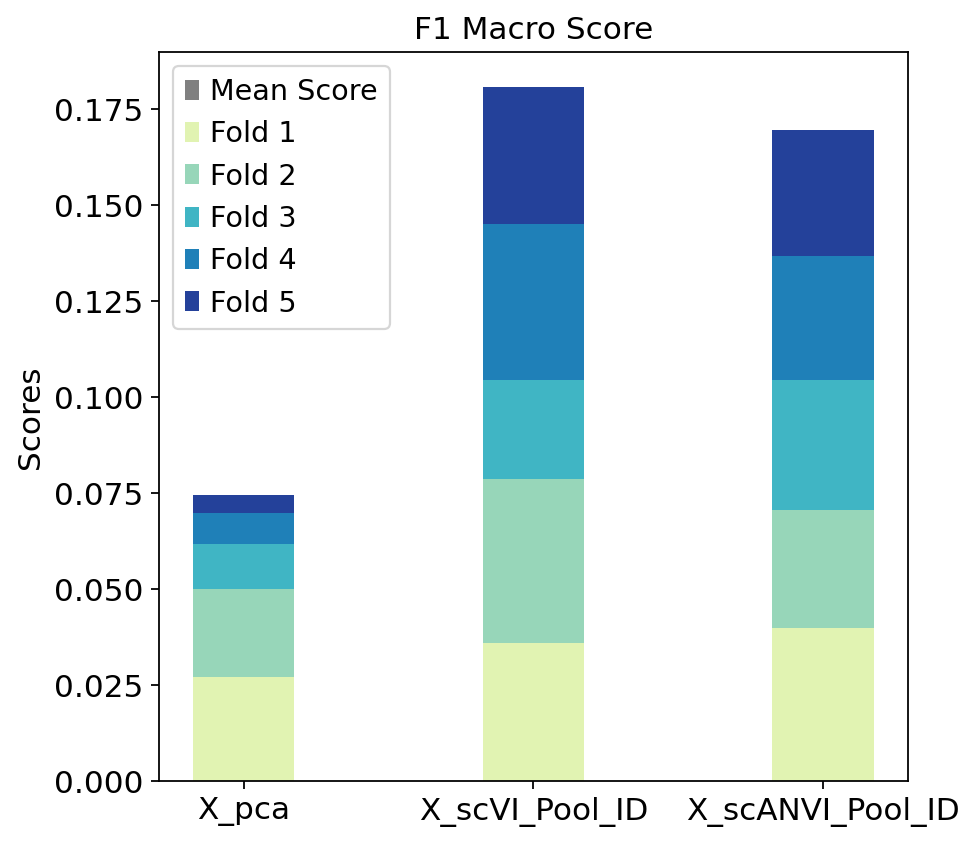

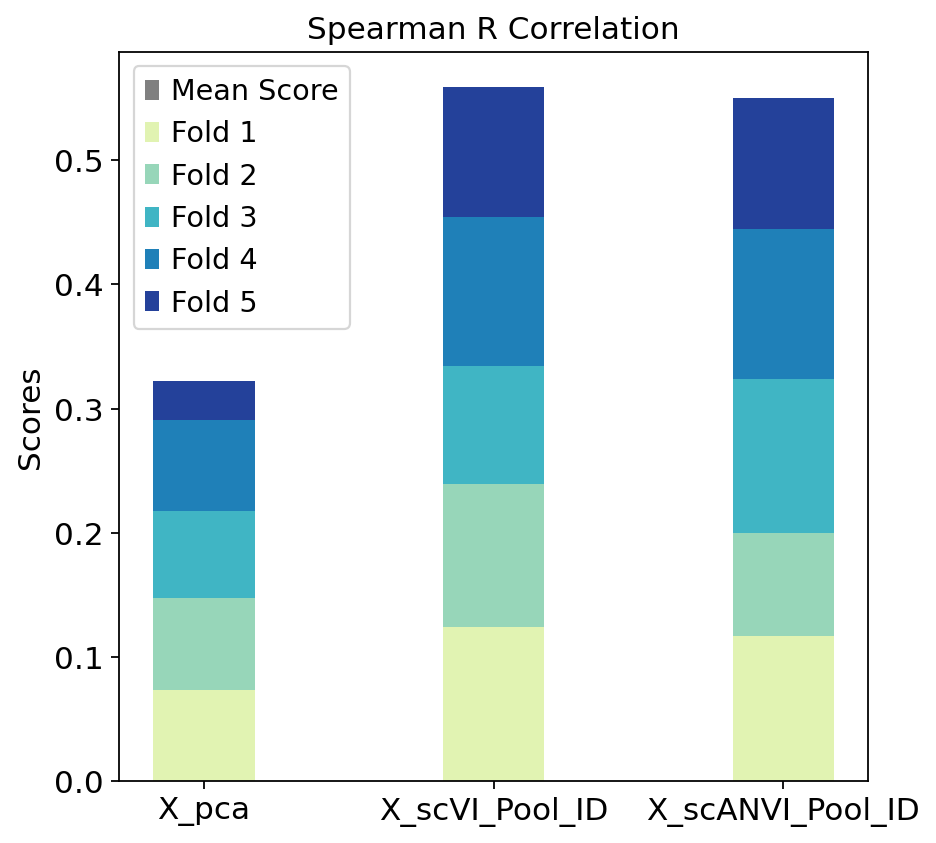

In [49]:
# Plotting F1 Macro scores and SCC scores for each fold of each layer
import seaborn as sns  
j=-1
for data, title in zip([all_layer_scores_f1, all_layer_scores_spearman], ['F1 Macro Score', 'Spearman R Correlation']):
    j+=1
    fig, ax = plt.subplots(figsize=(6, 6))
    palette = sns.color_palette("YlGnBu", n_colors=5)
    filename=['f1','spearman']
    # Calculate the mean score for each group
    mean_scores = [np.mean([d['score'] for d in sublist]) for sublist in data]
    
    # Extract individual scores for proportion calculation
    individual_scores = [[d['score'] for d in sublist] for sublist in data]
    # Calculate proportions of each score relative to the group's total score
    score_proportions = [[score/sum(group) for score in group] for group in individual_scores]
    
    ind = np.arange(len(data))  # Indices of the groups
    width = 0.35  # The width of the bars

    # Plot bars for mean scores
    ax.bar(ind, mean_scores, width, label='Mean Score', color='grey')

    # Overlay stacked bars showing individual score contributions
    bottoms = np.zeros(len(data))
    for i in range(5):  # Assume each list has exactly 5 dictionaries
        proportions = [score_proportions[j][i] * mean_scores[j] for j in range(len(data))]
        ax.bar(ind, proportions, width, bottom=bottoms, color=palette[i], label=f'Fold {i+1}')
        bottoms += proportions
    #ymin, ymax = ax.get_ylim()

    # Set new upper limit (e.g., increase by 10%)
    #ax.set_ylim(ymin, ymax + 0.1 * ymax)
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(['X_pca', 'X_scVI_Pool_ID', 'X_scANVI_Pool_ID'])
    ax.legend()
    ax.grid(False)
    plt.savefig(str(f'Plots/{filename[j]}_scores.png'), format='png', bbox_inches='tight',dpi=250)
    plt.show()




<Figure size 800x480 with 0 Axes>

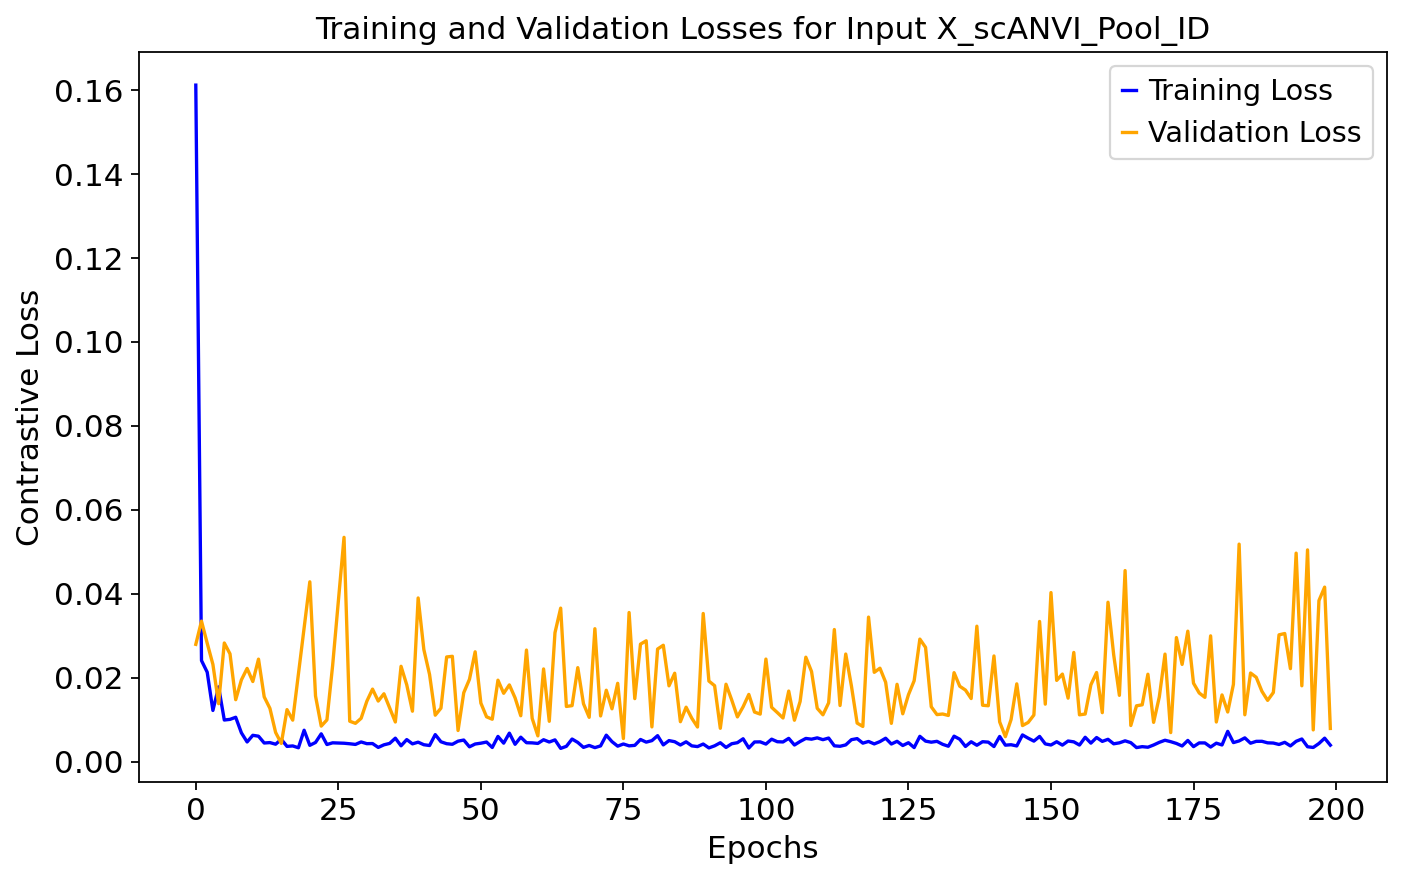

In [50]:
with open('/kaggle/input/representation-losses-k5/X_scANVI_Pool_ID_losses_dict.pkl', 'rb') as file:
    all_layer_losses=pickle.load(file)
# Plotting the first fold of each dictionary
plt.figure(figsize=(10, 6))

for layer in ['X_scANVI_Pool_ID']:
    # The first_subkey_value should be the tuple of arrays for training and validation losses
    train_losses, val_losses = [all_layer_losses.get(layer).get(key) for key in all_layer_losses.get(layer).keys()][0]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, color='blue', label='Training Loss')
    plt.plot(val_losses, color='orange', label='Validation Loss')
    plt.title('Training and Validation Losses for Input '+ layer )
    plt.xlabel('Epochs')
    plt.ylabel('Contrastive Loss')
    plt.legend()
    plt.grid()
    plt.show()

X_pca
X_scVI_Pool_ID
X_scANVI_Pool_ID


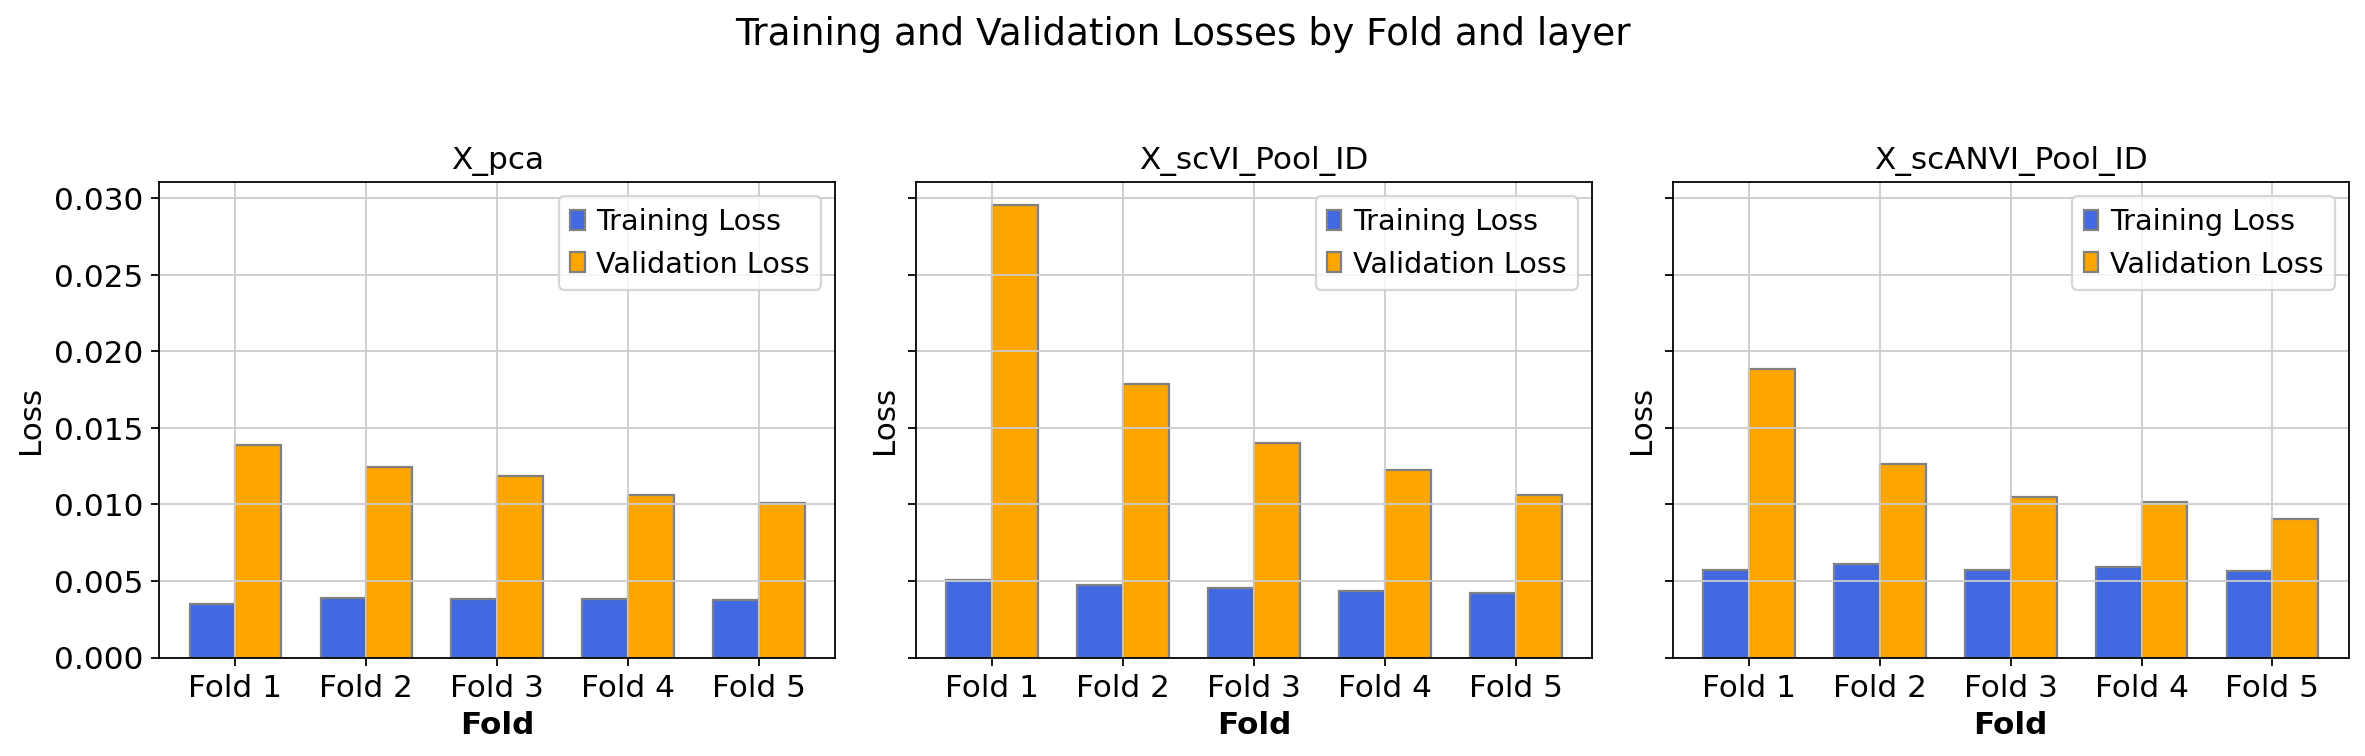

In [54]:
# Define file paths
avg_path = "/kaggle/input/representation-losses-k5/X_scANVI_Pool_ID_avg_losses_dict.pkl"


with open(avg_path, 'rb') as file:
    avg_losses=pickle.load(file)

# Setup figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Training and Validation Losses by Fold and layer')



# Iterate over each method and its corresponding data
for ax, layer in zip(axes, ['X_pca','X_scVI_Pool_ID','X_scANVI_Pool_ID']):
    print(layer)
    train_losses = [avg_losses.get(layer).get(key)[0] for key in avg_losses.get(layer).keys()]
    val_losses= [avg_losses.get(layer).get(key)[1] for key in avg_losses.get(layer).keys()]
    
# Define the positions of the bars
    bar_width = 0.35
    r1 = np.arange(len(train_losses))
    r2 = [x + bar_width for x in r1]
    
    # Plot the bars
    ax.bar(r1, train_losses, color='royalblue', width=bar_width, edgecolor='grey', label='Training Loss')
    ax.bar(r2, val_losses, color='orange', width=bar_width, edgecolor='grey', label='Validation Loss')
    
    # Add some details
    ax.set_title(layer)
    ax.set_xlabel('Fold', fontweight='bold')
    ax.set_xticks([r + bar_width / 2 for r in range(len(train_losses))])
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(train_losses))])
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [57]:
# import matplotlib.pyplot as plt
# import numpy as np

# file_paths_new = [
#     "/kaggle/input/representation-losses-k5/X_scVI_Pool_ID_losses_dict.pkl",
#     "/kaggle/input/representation-losses-k5/X_scANVI_Pool_ID_losses_dict.pkl",
#     "/kaggle/input/representation-losses-k5/X_pca_losses_dict.pkl"
# ]

# # Load the data from the new pickle files
# full_data_dicts = []
# for file_path in file_paths_new:
#     with open(file_path, 'rb') as file:
#         full_data_dicts.append(pickle.load(file))

# # Setup figure and axes for the new visualization
# fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
# fig.suptitle('Training and Validation Losses by Fold and layer')

# # Define a function to add individual data points to the bar plots
# def add_scatter_to_bars(ax, bar_centers, data_points, bar_width, color):
#     # Spread the data points around the center of the bar
#     spread = np.linspace(-bar_width / 2, bar_width / 2, len(data_points))
#     for idx, point in enumerate(data_points):
#         ax.scatter(bar_centers + spread[idx], point, color=color, alpha=0.7)

# # Iterate over each method and its corresponding data for plotting
# for ax, method, data_dict in zip(axes, methods, full_data_dicts):
#     # Initialize lists to store mean and standard deviation for the bars
#     train_means, train_stds, val_means, val_stds = [], [], [], []
#     # Extract individual data points for scatter plots
#     train_data_points, val_data_points = [], []
    
#     # Gather the statistics and data points for each fold
#     for fold in data_dict[method]:
#         train_losses, val_losses = data_dict[method][fold]
#         train_means.append(np.mean(train_losses))
#         train_stds.append(np.std(train_losses))
#         val_means.append(np.mean(val_losses))
#         val_stds.append(np.std(val_losses))
#         train_data_points.append(train_losses)
#         val_data_points.append(val_losses)
        
#     # Define the positions of the bars
#     bar_width = 0.35
#     r1 = np.arange(len(train_means))
#     r2 = [x + bar_width for x in r1]
    
#     # Plot the bars for training and validation losses with error bars
#     ax.bar(r1, train_means, yerr=train_stds, color='royalblue', width=bar_width, edgecolor='grey', label='Training Loss')
#     ax.bar(r2, val_means, yerr=val_stds, color='orange', width=bar_width, edgecolor='grey', label='Validation Loss')
    
#     # Add individual data points as scatter over the bars
#     for idx, r in enumerate(r1):
#         add_scatter_to_bars(ax, r, train_data_points[idx], bar_width, 'royalblue')
#         add_scatter_to_bars(ax, r2[idx], val_data_points[idx], bar_width, 'orange')
    
#     # Add some details to the subplot
#     ax.set_title(method)
#     ax.set_xlabel('Fold', fontweight='bold')
#     ax.set_xticks([r + bar_width / 2 for r in range(len(train_means))])
#     ax.set_xticklabels([f'Fold {i+1}' for i in range(len(train_means))])
#     ax.set_ylabel('Loss')
#     ax.legend()

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

